# Riemannian Synthetic Geodesics

In [1]:
#Modules
import jax.numpy as jnp
import jax.random as jrandom
from jax import vmap

from abc import ABC

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

import os

from geometry.geodesics.riemannian import GradientDescent, JAXOptimization, ScipyOptimization, GEORCE
from geometry.manifolds.riemannian import nEllipsoid, nSphere, nParaboloid, T2

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
plt.rcParams.update({'font.size': 20})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [3]:
figure_path = '../figures/geodesic_synthetic_plot/'

In [4]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Hyper-Parameters

In [5]:
tol = 1e-4
max_iter = 100
T = 100
line_search_iter = 100

### Gradient Descent

In [6]:
grad_decay = 0.90
grad_lr_rate = 1.0

### JAX Optimization

In [7]:
jax_lr_rate = 0.001

### Geodesic Control

In [8]:
gc_decay = 0.9
gc_lr_rate = 1.0

### Estimation Plot 

In [9]:
def compute_estimates(M, Geodesic, z0, zT, base_curve):
    
    new_method = {}
    zt, grad, idx = Geodesic(z0,zT, "while")
    xt = vmap(lambda z: M.f(z))(zt)
    length = M.length(zt)
    
    new_method['zt'] = zt
    new_method['grad'] = grad
    new_method['idx'] = idx
    new_method['xt'] = xt
    new_method['length'] = length
    
    zt, grad, _ = Geodesic(z0,zT, "for")
    error_base_curve = vmap(lambda z: jnp.linalg.norm(z-base_curve))(zt)
    error_iter_curve = vmap(lambda z1,z2: jnp.linalg.norm(z1-z2))(zt[1:], zt[:-1])
    grad_curve = vmap(lambda z: jnp.linalg.norm(Geodesic.Denergy(z)))(zt)
    
    new_method['error_base_curve'] = error_base_curve
    new_method['error_iter_curve'] = error_iter_curve
    new_method['grad_curve'] = grad_curve
    
    return new_method

In [10]:
def compute_methods(M, z0, zT):
    
    estimates = {}
    
    Geodesic = GEORCE(M=M,
                      init_fun=None,
                      T=T,
                      line_search_method="soft",
                      max_iter=max_iter,
                     )
    base_curve, *_ = Geodesic(z0,zT, "while")
    
    #Gradient descent
    Geodesic = GradientDescent(M = M,
                               init_fun=None,
                               T=T,
                               max_iter=max_iter,
                               tol=tol,
                               line_search_method="soft",
                              )
    estimates['Gradient Descent'] = compute_estimates(M, Geodesic, z0, zT, base_curve)

    Geodesic = JAXOptimization(M = M,
                              init_fun=None,
                              lr_rate=jax_lr_rate,
                              optimizer=None,
                              T=T,
                              max_iter=max_iter,
                              tol=tol)
    estimates['ADAM'] = compute_estimates(M, Geodesic, z0, zT, base_curve)

    Geodesic = ScipyOptimization(M = M,
                                 T=T,
                                 tol=tol,
                                 max_iter=max_iter,
                                 method="BFGS",
                                )
    estimates['BFGS'] = compute_estimates(M, Geodesic, z0, zT, base_curve)
    
    Geodesic = GEORCE(M=M,
                      init_fun=None,
                      T=T,
                      line_search_method="soft",
                      max_iter=max_iter,
                     )
    estimates['GEORCE'] = compute_estimates(M, Geodesic, z0, zT, base_curve)
    
    zt = Geodesic.init_fun(z0,zT, T)
    xt = vmap(lambda z: M.f(z))(zt)
    length = M.length(zt)
    
    new_method = {}
    new_method['zt'] = zt
    new_method['grad'] = None
    new_method['idx'] = None
    new_method['xt'] = xt
    new_method['length'] = length
    estimates['Initilization'] = new_method
    
    return estimates

## Estimating Geodesics

### Ellipsoid(2)

In [11]:
params = jnp.linspace(0.5,1.0,3)[::-1]
M = nEllipsoid(dim=2, params=params)
z0 = -jnp.linspace(0,1,2)
zT = jnp.ones(2, dtype=jnp.float32)

e2_x0 = M.f(z0)
e2_xT = M.f(zT)

ellipsoid_methods = compute_methods(M, z0, zT)

(100, 2)
(99, 2)
(100, 2, 2)
(100, 2)
(99, 2)
(100, 2, 2)


In [12]:
GEORCE(M)(z0,zT)

(Array([[-0.        , -1.        ],
        [ 0.01809463, -1.0051303 ],
        [ 0.03637578, -1.0099547 ],
        [ 0.05484312, -1.0144677 ],
        [ 0.07349622, -1.018664  ],
        [ 0.09233464, -1.0225375 ],
        [ 0.11135782, -1.0260819 ],
        [ 0.13056515, -1.029291  ],
        [ 0.14995591, -1.0321581 ],
        [ 0.16952929, -1.034676  ],
        [ 0.18928435, -1.0368375 ],
        [ 0.20922005, -1.0386347 ],
        [ 0.2293352 , -1.0400599 ],
        [ 0.24962844, -1.0411047 ],
        [ 0.27009827, -1.0417604 ],
        [ 0.29074296, -1.042018  ],
        [ 0.31156063, -1.0418683 ],
        [ 0.33254918, -1.0413015 ],
        [ 0.35370624, -1.0403074 ],
        [ 0.3750292 , -1.0388756 ],
        [ 0.39651513, -1.0369952 ],
        [ 0.4181609 , -1.0346547 ],
        [ 0.4399629 , -1.0318427 ],
        [ 0.46191728, -1.0285469 ],
        [ 0.48401976, -1.0247548 ],
        [ 0.50626564, -1.0204531 ],
        [ 0.5286497 , -1.0156285 ],
        [ 0.55116636, -1.010

### $\mathbb{S}^{2}$

In [12]:
M = nSphere(dim=2)
z0 = -jnp.linspace(0,1,2)
zT = jnp.ones(2, dtype=jnp.float32)

s2_x0 = M.f(z0)
s2_xT = M.f(zT)

sphere_methods = compute_methods(M, z0, zT)

### Paraboloid(2)

In [13]:
M = nParaboloid(dim=2)
z0 = -jnp.linspace(0,1,2)
zT = jnp.ones(2)

p2_x0 = M.f(z0)
p2_xT = M.f(zT)

paraboloid_methods = compute_methods(M, z0, zT)

### $\mathbb{T}^{2}$

In [14]:
M = T2(R=3.0, r=1.0)
z0 = jnp.array([0.0, 0.0])
zT = jnp.array([5*jnp.pi/4, 5*jnp.pi/4])

t2_x0 = M.f(z0)
t2_xT = M.f(zT)

torus_methods = compute_methods(M, z0, zT)

## Plotting Geodesics

In [15]:
class EllipsoidPlot(ABC):
    def __init__(self, params=jnp.linspace(0.5,1.0,3)[::-1]):
        
        self.params = params

    def grid(self, n_points:int=100):
        
        theta = jnp.linspace(0.0, jnp.pi*1, n_points)
        phi   = jnp.linspace(0.0, jnp.pi*2, n_points)

        # Creating the coordinate grid for the unit sphere.
        x1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
        x2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
        x3 = jnp.outer(jnp.cos(theta), jnp.ones(n_points))
        
        return self.params[0]*x1,self.params[1]*x2,self.params[2]*x3
         

In [16]:
class TorusPlot(ABC):
    def __init__(self, R:float=3.0, r:float=1.0):
        
        self.R = R
        self.r = r
        
    def grid(self, n_points:int=100):
        
        U = jnp.linspace(0, 2*jnp.pi, n_points)
        V = jnp.linspace(0, 2*jnp.pi, n_points)
        U, V = jnp.meshgrid(U, V)
        X = (self.R+self.r*jnp.cos(V))*jnp.cos(U)
        Y = (self.R+self.r*jnp.cos(V))*jnp.sin(U)
        Z = self.r*jnp.sin(V)
        
        return X, Y, Z

In [17]:
class ParaboloidPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2+X2**2

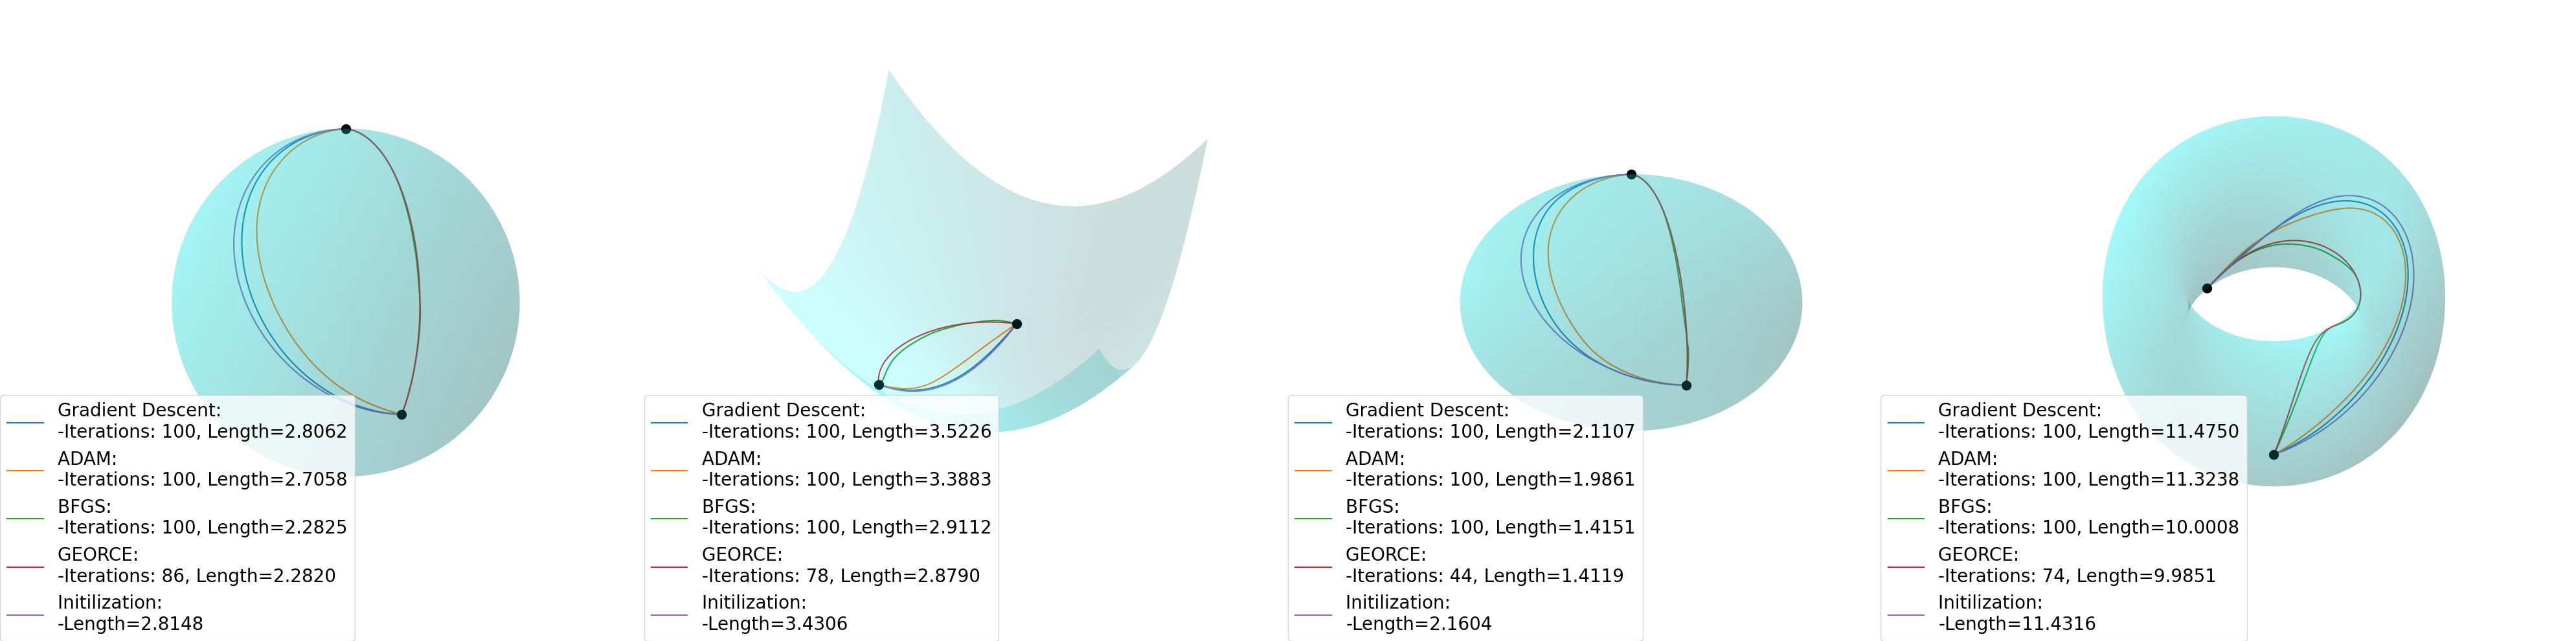

In [18]:
fig = plt.figure(figsize=(40,10))

#plotting sphere
plot_sphere = EllipsoidPlot(params=jnp.ones(3))
x1,x2,x3 = plot_sphere.grid(100)
ax = fig.add_subplot(141, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
for key, value in sphere_methods.items():
    if value['idx'] is not None:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
            label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}")
    else:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Length={value['length']:.4f}")

    
ax.scatter(s2_x0[0], s2_x0[1], s2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(s2_xT[0], s2_xT[1], s2_xT[2], color='black', alpha=1.0, s=100)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.0,0.0), ncol=1)

#plotting paraboloid
plot_sphere = ParaboloidPlot()
x1,x2,x3 = plot_sphere.grid(100)
ax = fig.add_subplot(142, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
for key, value in paraboloid_methods.items():
    if value['idx'] is not None:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
            label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}")
    else:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Length={value['length']:.4f}")

    
ax.scatter(p2_x0[0], p2_x0[1], p2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(p2_xT[0], p2_xT[1], p2_xT[2], color='black', alpha=1.0, s=100)
#ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=40., azim=110.)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.25,0.0), ncol=1)

#plotting Ellipsoid
plot_sphere = EllipsoidPlot()
x1,x2,x3 = plot_sphere.grid(100)
ax = fig.add_subplot(143, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
for key, value in ellipsoid_methods.items():
    if value['idx'] is not None:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
            label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}")
    else:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Length={value['length']:.4f}")

    
ax.scatter(e2_x0[0], e2_x0[1], e2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(e2_xT[0], e2_xT[1], e2_xT[2], color='black', alpha=1.0, s=100)
#ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.5, 0.0), ncol=1)

#plotting Torus
plot_sphere = TorusPlot(R=3.0, r=1.0)
x1,x2,x3 = plot_sphere.grid(100)
ax = fig.add_subplot(144, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
for key, value in torus_methods.items():
    if value['idx'] is not None:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
            label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}")
    else:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Length={value['length']:.4f}")

    
ax.scatter(t2_x0[0], t2_x0[1], t2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(t2_xT[0], t2_xT[1], t2_xT[2], color='black', alpha=1.0, s=100)
#ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=60., azim=0)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.73, 0.0), ncol=1)

fig.tight_layout()

save_path = f'{figure_path}synthetic_geodesics.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()




## Plotting Gradients

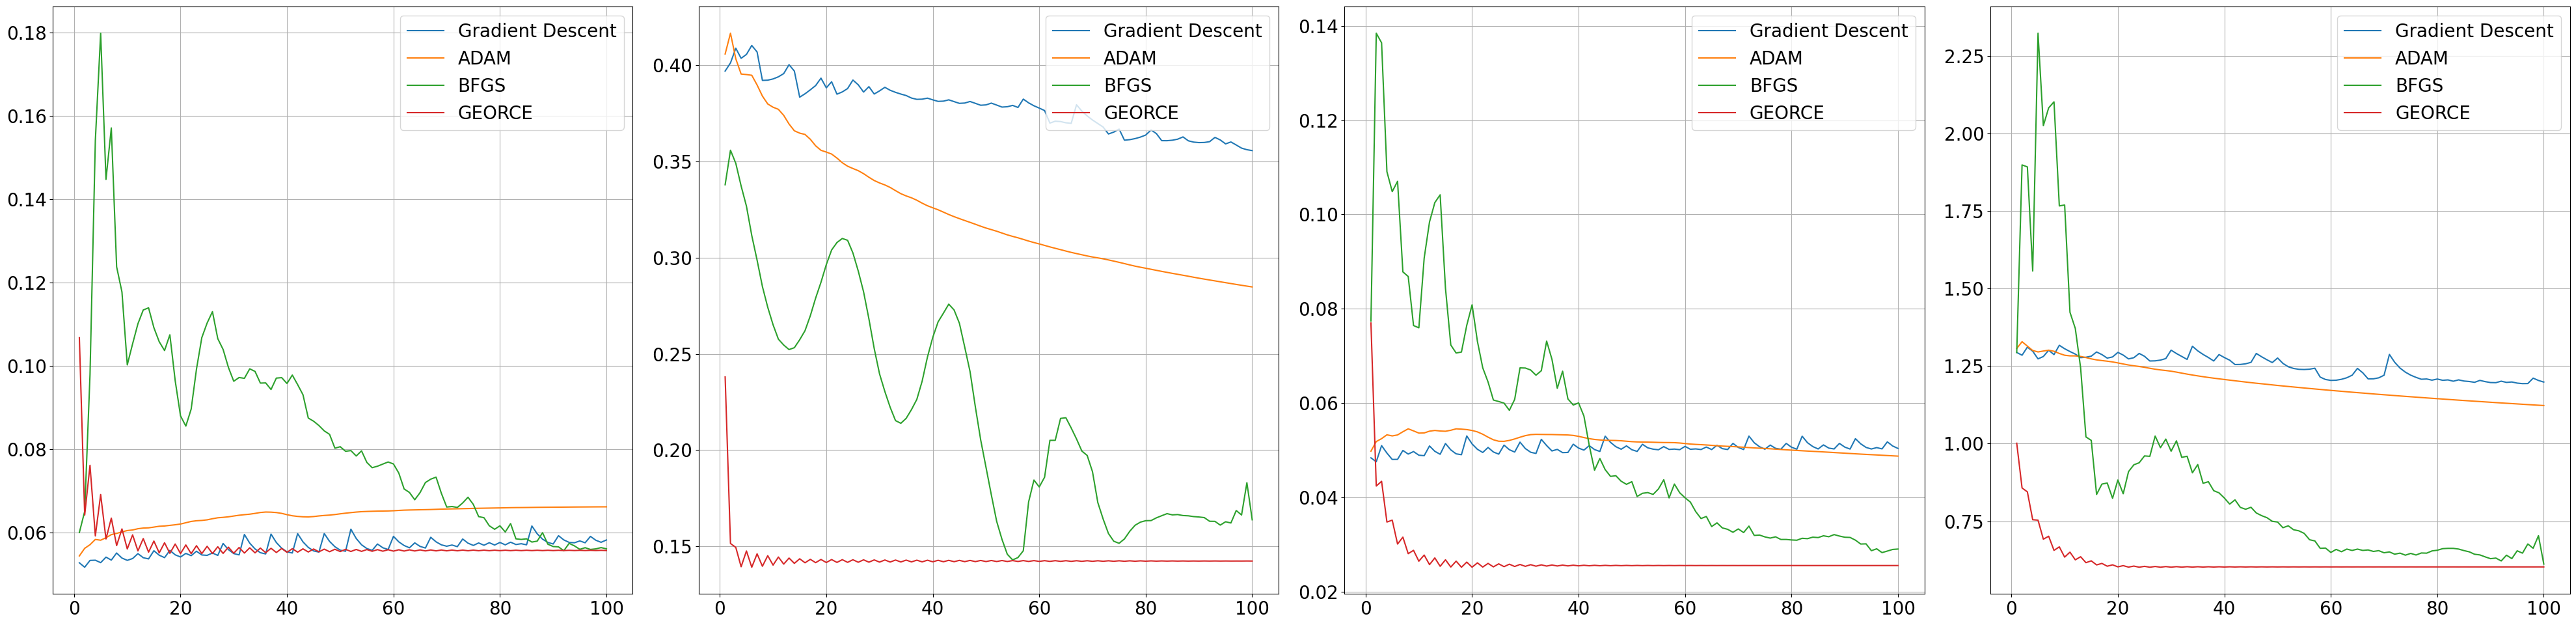

In [19]:
fig = plt.figure(figsize=(40,10))

ax = fig.add_subplot(141)
for key, value in sphere_methods.items():
    if value['grad'] is not None:
        ax.plot(jnp.arange(1,len(value['grad_curve'])+1,1), value['grad_curve'], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

ax = fig.add_subplot(142)
for key, value in paraboloid_methods.items():
    if value['grad'] is not None:
        ax.plot(jnp.arange(1,len(value['grad_curve'])+1,1), value['grad_curve'], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

ax = fig.add_subplot(143)
for key, value in ellipsoid_methods.items():
    if value['grad'] is not None:
        ax.plot(jnp.arange(1,len(value['grad_curve'])+1,1), value['grad_curve'], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

ax = fig.add_subplot(144)
for key, value in torus_methods.items():
    if value['grad'] is not None:
        ax.plot(jnp.arange(1,len(value['grad_curve'])+1,1), value['grad_curve'], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

fig.tight_layout()

save_path = f'{figure_path}synthetic_gradients.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()



## Plotting Convergence

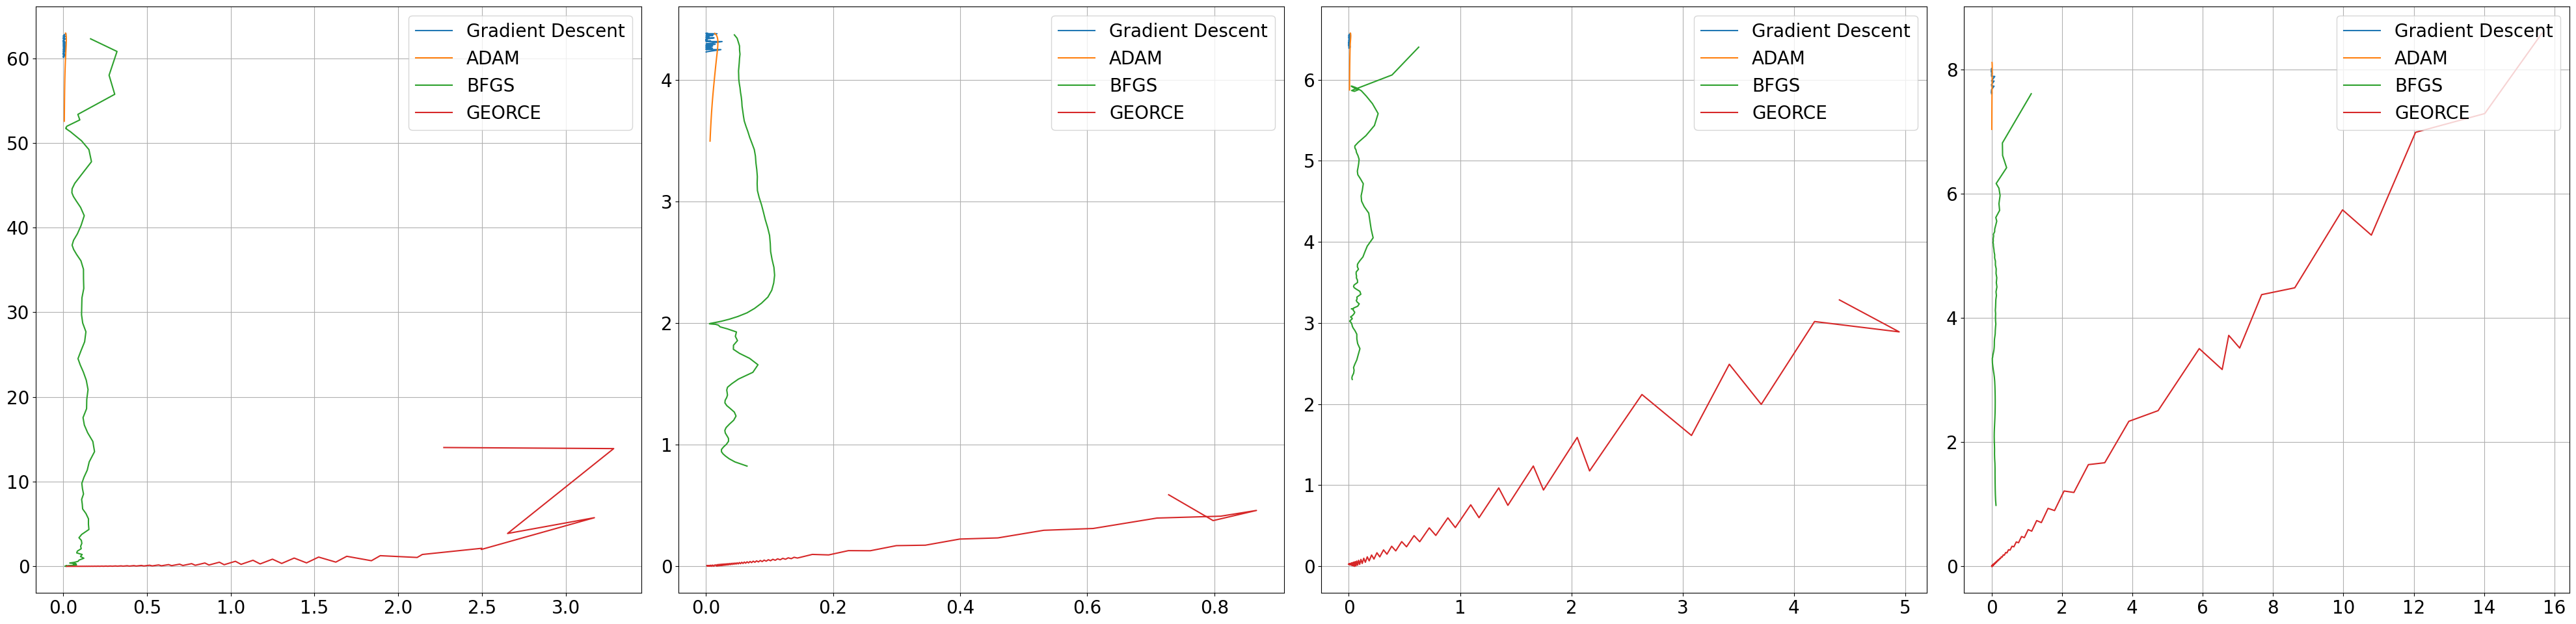

In [20]:
fig = plt.figure(figsize=(40,10))

ax = fig.add_subplot(141)
for key, value in sphere_methods.items():
    if value['grad'] is not None:
        ax.plot(value['error_iter_curve'], value['error_base_curve'][:-1]**2, 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

ax = fig.add_subplot(142)
for key, value in paraboloid_methods.items():
    if value['grad'] is not None:
        ax.plot(value['error_iter_curve'], value['error_base_curve'][:-1], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

ax = fig.add_subplot(143)
for key, value in ellipsoid_methods.items():
    if value['grad'] is not None:
        ax.plot(value['error_iter_curve'], value['error_base_curve'][:-1], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

ax = fig.add_subplot(144)
for key, value in torus_methods.items():
    if value['grad'] is not None:
        ax.plot(value['error_iter_curve'], value['error_base_curve'][:-1], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

fig.tight_layout()

save_path = f'{figure_path}synthetic_convergence.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

